In [2]:
# import all libraries

import pandas as pd
import numpy as np


# Ignore harmless warnings
import warnings
warnings.filterwarnings("ignore")   

import matplotlib.pyplot as plt
import seaborn as sns
from pandas.plotting import autocorrelation_plot

# For time stamps
from datetime import datetime

from scipy.stats import norm, skew #for some statistics
from scipy import stats #qqplot
import statsmodels.api as sm #for decomposing the trends, seasonality etc.

from sklearn.model_selection import train_test_split

import statsmodels.graphics.tsaplots as sgt
from sklearn.preprocessing import StandardScaler
# ARIMA
from statsmodels.tsa.arima.model import ARIMA


# import pmdarima as pm
# from pmdarima.arima import auto_arima
from sklearn.metrics import mean_squared_error, mean_absolute_error
import math
from statsmodels.graphics.tsaplots import plot_acf, plot_pacf

# import ensemble models

from sklearn.ensemble import RandomForestRegressor
from sklearn.ensemble import GradientBoostingRegressor

from sklearn.metrics import confusion_matrix,accuracy_score,f1_score,recall_score,precision_score,roc_auc_score


In [3]:
# read train test 
train = pd.read_csv("train.csv")
test = pd.read_csv("test.csv")

In [4]:
data= train.copy()

In [5]:
data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,Hold
1,1,2015-06-08,64.116235,74.443331,227974800,Hold
2,2,2015-06-15,47.701942,71.140831,250670900,Buy
3,3,2015-06-22,54.754816,72.881344,223614300,Hold
4,4,2015-06-29,48.031899,66.284718,406814900,Buy


In [6]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype  
---  ------    --------------  -----  
 0   id        300 non-null    int64  
 1   Date      300 non-null    object 
 2   Open      300 non-null    float64
 3   Close     300 non-null    float64
 4   Volume    300 non-null    int64  
 5   Strategy  300 non-null    object 
dtypes: float64(2), int64(2), object(2)
memory usage: 14.2+ KB


In [7]:
data.describe()

,id,Open,Close,Volume
count,300.000000,300.000000,300.000000,3.000000e+02
mean,149.500000,75.977813,79.430489,1.866300e+08
std,86.746758,16.158343,13.878395,7.952792e+07
min,0.000000,40.269435,47.979353,5.991330e+07
25%,74.750000,64.872395,69.689227,1.324862e+08
50%,149.500000,79.805683,82.991900,1.715536e+08
75%,224.250000,88.342927,89.719145,2.201842e+08
max,299.000000,102.558322,103.119373,6.935702e+08


In [8]:
data.shape

(300, 6)

# Data Preprocessing

### Check for missing data points

In [9]:
data.isnull().sum()

id          0
Date        0
Open        0
Close       0
Volume      0
Strategy    0
dtype: int64

No missing data points in train data

### Preprocess Data

- Hold - 1
- Buy - 2
- Sell - 0

In [10]:
# classify Strategy as categorical variable
# label Strategy
data['Strategy'] = data['Strategy'].astype('category')
data['Strategy'] = data['Strategy'].map({"Hold":1,"Buy":2,"Sell":0})
data['Strategy'].value_counts()

# convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,1
1,1,2015-06-08,64.116235,74.443331,227974800,1
2,2,2015-06-15,47.701942,71.140831,250670900,2
3,3,2015-06-22,54.754816,72.881344,223614300,1
4,4,2015-06-29,48.031899,66.284718,406814900,2


In [11]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 300 entries, 0 to 299
Data columns (total 6 columns):
 #   Column    Non-Null Count  Dtype         
---  ------    --------------  -----         
 0   id        300 non-null    int64         
 1   Date      300 non-null    datetime64[ns]
 2   Open      300 non-null    float64       
 3   Close     300 non-null    float64       
 4   Volume    300 non-null    int64         
 5   Strategy  300 non-null    category      
dtypes: category(1), datetime64[ns](1), float64(2), int64(2)
memory usage: 12.3 KB


### Check for Outliers

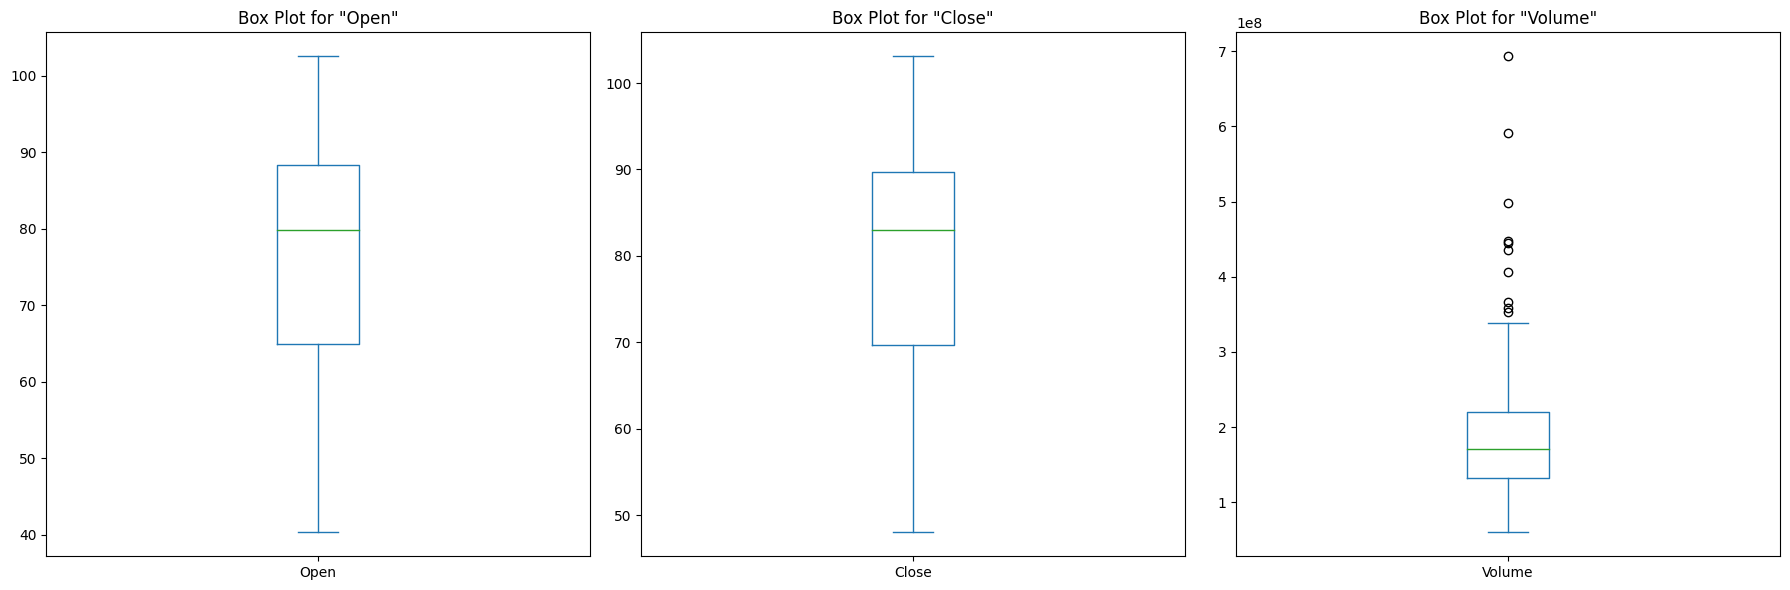

In [12]:
fig, axes = plt.subplots(nrows=1, ncols=3, figsize=(18, 6))
# Create box plots for 'Open,' 'Close,' and 'Volume' columns
data[['Open']].plot(kind='box', ax=axes[0])
data[['Close']].plot(kind='box', ax=axes[1])
data[['Volume']].plot(kind='box', ax=axes[2])

# Set titles for each subplot
axes[0].set_title('Box Plot for "Open"')
axes[1].set_title('Box Plot for "Close"')
axes[2].set_title('Box Plot for "Volume"')

# Adjust layout and show the plots
plt.tight_layout()
plt.show()



As due to some reasons the volume of a stock may increase. So, we are avoiding to remove it.

### Building a Scatter plot for volume to check if outliers are accumulated at a particular year


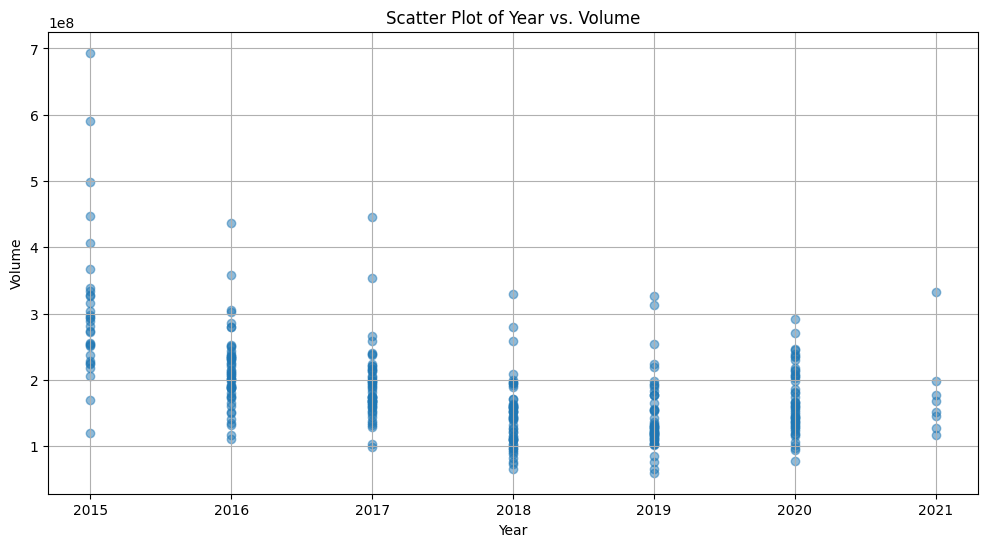

In [13]:
# Convert the "Date" column to a datetime object
Date= pd.to_datetime(data['Date'])
# Extract the year from the "Date" column
Year=Date.dt.year

# Create a scatter plot of Year vs. Volume
plt.figure(figsize=(12, 6))
plt.scatter(Year, data['Volume'], alpha=0.5)
plt.title("Scatter Plot of Year vs. Volume")
plt.xlabel("Year")
plt.ylabel("Volume")
plt.grid(True)
plt.show()


# Data Visualization

<AxesSubplot:>

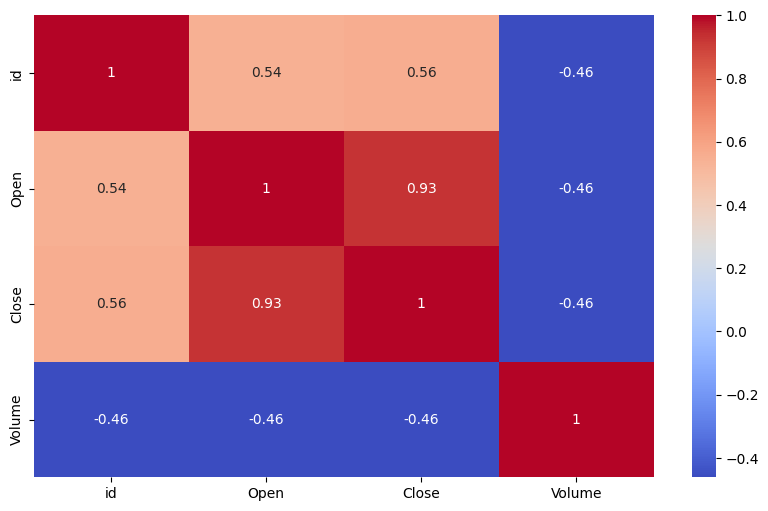

In [14]:
corr = data.corr()

plt.figure(figsize=(10, 6))
sns.heatmap(corr, annot=True, cmap='coolwarm')

<AxesSubplot:xlabel='Close', ylabel='Density'>

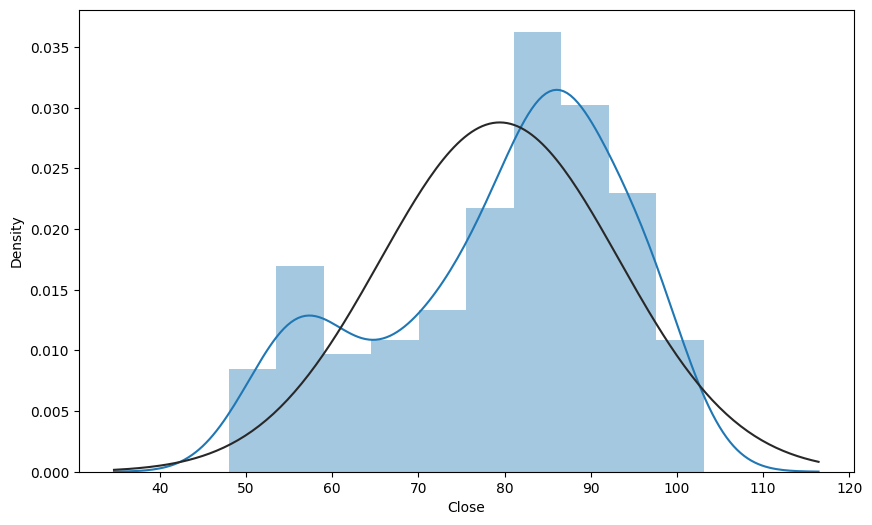

In [15]:
plt.figure(figsize=(10,6))
sns.distplot(data['Close'], fit=norm)

<AxesSubplot:xlabel='Open', ylabel='Density'>

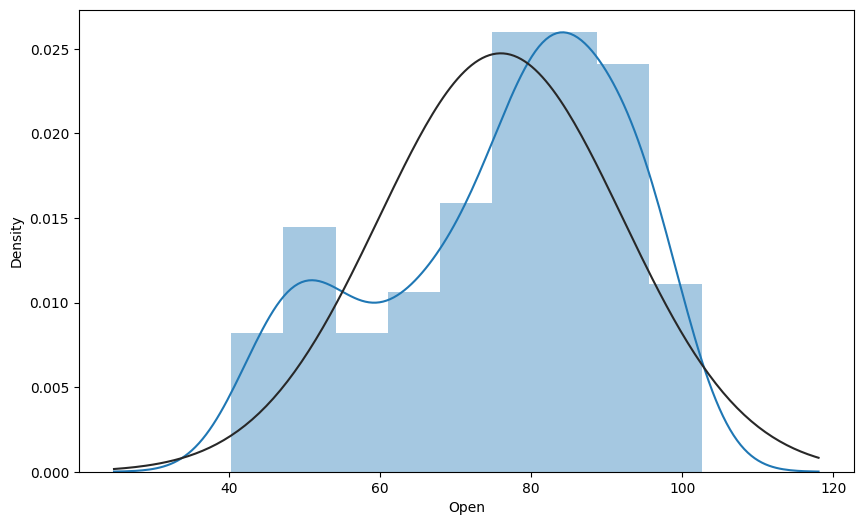

In [16]:
plt.figure(figsize=(10,6))
sns.distplot(data['Open'], fit=norm)

<AxesSubplot:xlabel='Volume', ylabel='Density'>

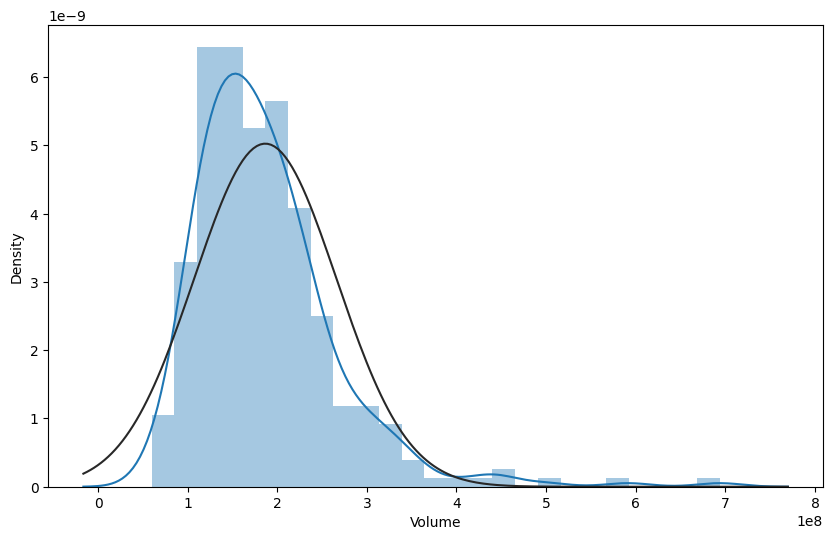

In [17]:
plt.figure(figsize=(10,6))
sns.distplot(data['Volume'], fit=norm)

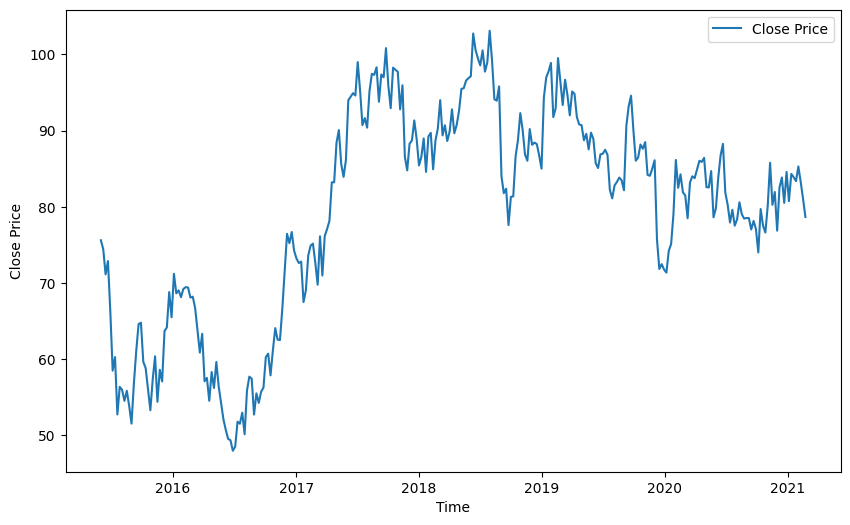

In [18]:
# Plot the data
plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Close'], label='Close Price')
plt.xlabel('Time')

plt.ylabel('Close Price')
plt.legend()


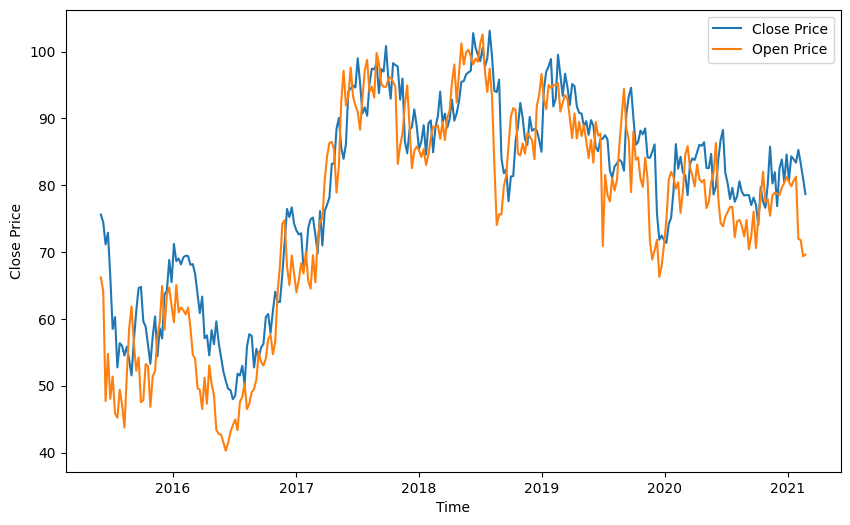

In [19]:
# plot open vs close price over the years

plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Close'], label='Close Price')
plt.plot(data['Date'], data['Open'], label='Open Price')

plt.xlabel('Time')

plt.ylabel('Close Price')

plt.legend()

plt.show()

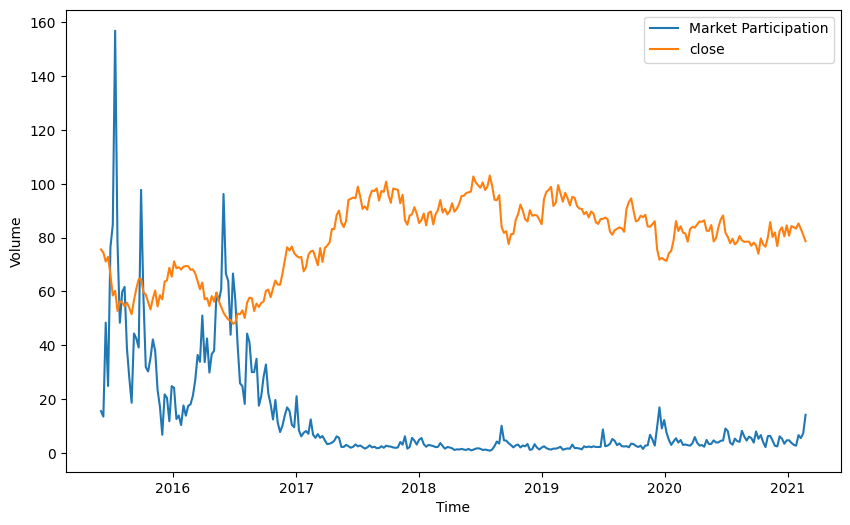

In [20]:
# plot volume over the years

plt.figure(figsize=(10, 6))

plt.plot(data['Date'], data['Volume']/(data['Open'])**4, label='Market Participation')
plt.plot(data['Date'], data['Close'], label='close')


plt.xlabel('Time')

plt.ylabel('Volume')

plt.legend()

plt.show()

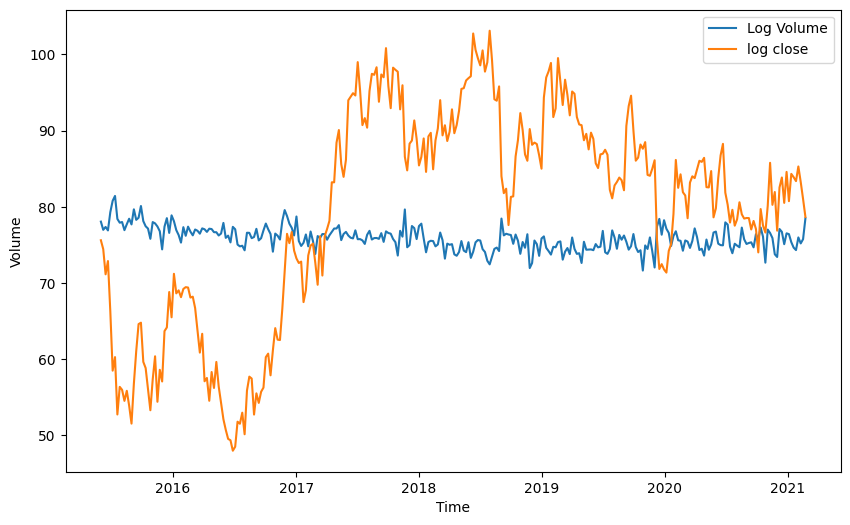

In [21]:
# plot volume over the years

plt.figure(figsize=(10, 6))

plt.plot(data['Date'], 4*np.log(data['Volume']), label='Log Volume')
plt.plot(data['Date'], data['Close'], label='log close')


plt.xlabel('Time')

plt.ylabel('Volume')

plt.legend()

plt.show()

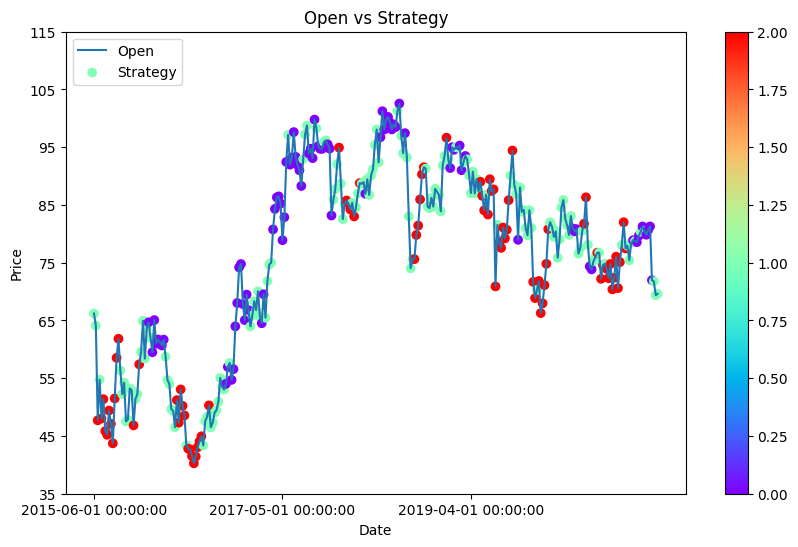

In [22]:
# plot between open and strategy over the period of time

plt.figure(figsize=(10,6))
plt.plot(data['Open'])
# colour code curve for different strategy

plt.scatter(data.index, data['Open'], c=data['Strategy'], cmap='rainbow')
plt.colorbar()


plt.title('Open vs Strategy')
plt.ylabel('Price')
plt.xlabel('Date')

plt.legend(['Open','Strategy'], loc='upper left')
# set x axis to have date's year
plt.xticks(np.arange(0,300, 100), data['Date'][0:300:100])
plt.yticks(np.arange(35, 120, 10))

plt.show()


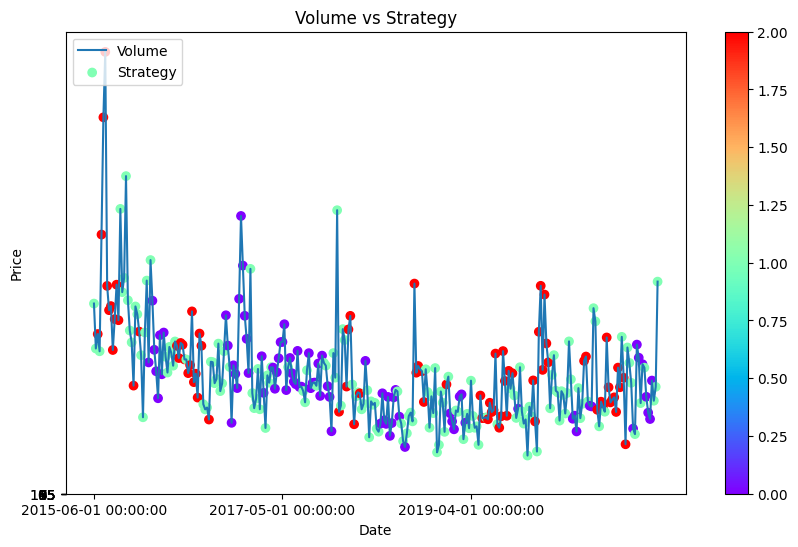

In [23]:
# plot between Volume and strategy over the period of time

plt.figure(figsize=(10,6))
plt.plot(data['Volume'])
# colour code curve for different strategy

plt.scatter(data.index, data['Volume'], c=data['Strategy'], cmap='rainbow')
plt.colorbar()


plt.title('Volume vs Strategy')
plt.ylabel('Price')
plt.xlabel('Date')

plt.legend(['Volume','Strategy'], loc='upper left')
# set x axis to have date's year
plt.xticks(np.arange(0,300, 100), data['Date'][0:300:100])
plt.yticks(np.arange(35, 120, 10))

plt.show()


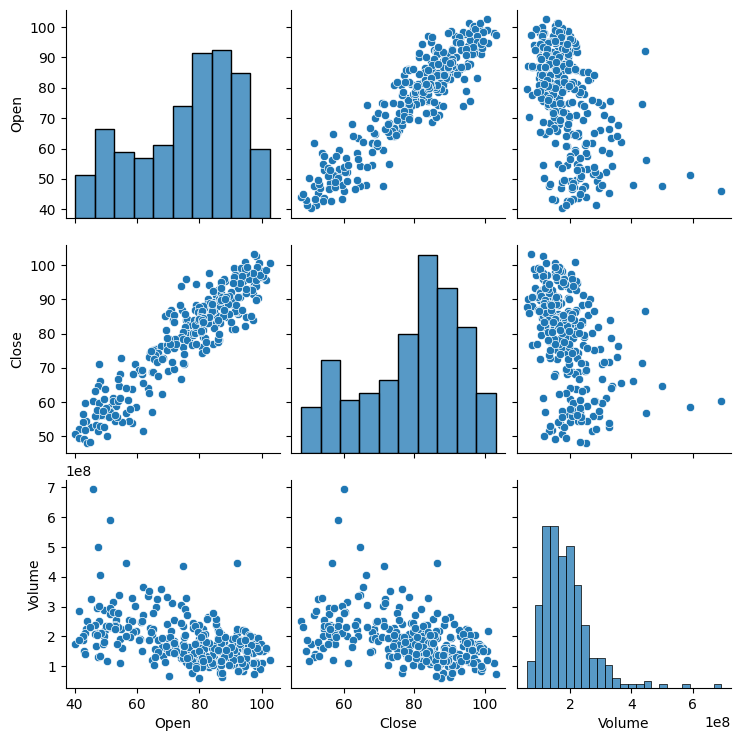

In [24]:
sns.pairplot(data, vars=['Open','Close', 'Volume'])
plt.show()

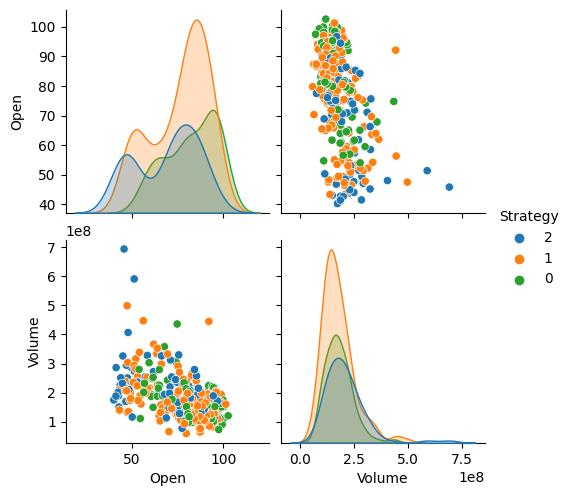

In [25]:
sns.pairplot(data[["Open","Volume","Strategy","Date"]],hue="Strategy")

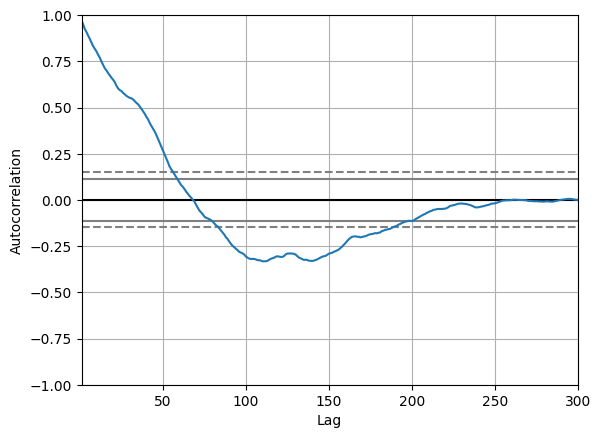

In [26]:
autocorrelation_plot(data['Open'])
plt.show()

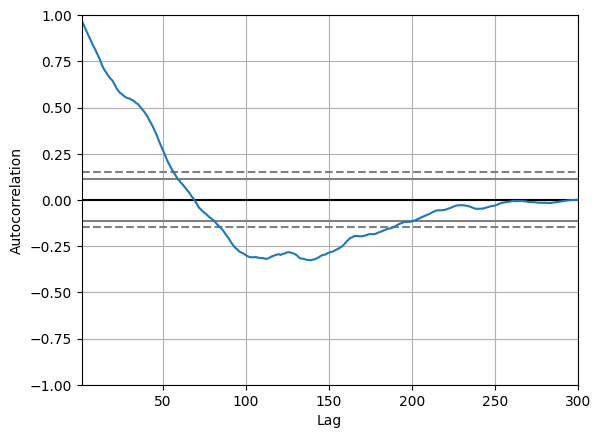

In [27]:
autocorrelation_plot(data['Close'])
plt.show()

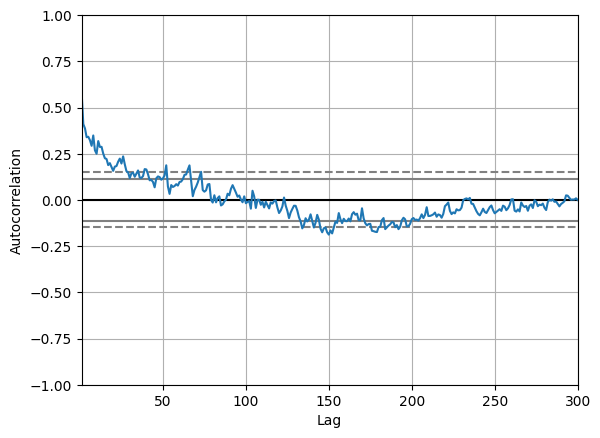

In [28]:
autocorrelation_plot(data['Volume'])
plt.show()

By visual inspection, Open price and close price are out of their confidence interval, suggesting that they are non- stationary points, whereas Volume is stationary

### Check for Seasonality

In [29]:
data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,1
1,1,2015-06-08,64.116235,74.443331,227974800,1
2,2,2015-06-15,47.701942,71.140831,250670900,2
3,3,2015-06-22,54.754816,72.881344,223614300,1
4,4,2015-06-29,48.031899,66.284718,406814900,2


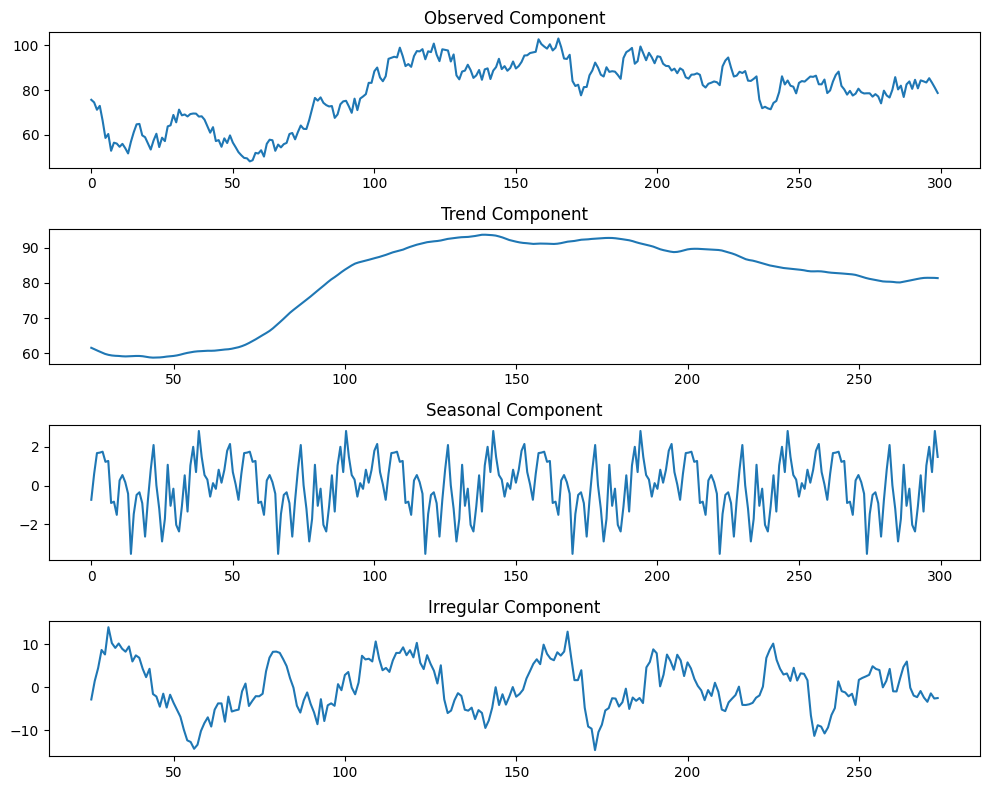

In [30]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Perform seasonal decomposition
result = seasonal_decompose(data['Close'].values, model='additive', period=52)

# Plot the components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title("Observed Component")

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title("Trend Component")

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title("Seasonal Component")

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title("Irregular Component")

plt.tight_layout()
plt.show()


In [31]:
from statsmodels.tsa.stattools import adfuller

val = data['Close'].values

result = adfuller(val)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -1.808006
p-value: 0.376494
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


We fail to reject the null hypothesis. This suggests that there is not enough evidence to conclude that the time series is stationary.

If the p-value is less than 0.05 and the ADF statistic is less than the critical values, then you can reject the null hypothesis and say that your data is stationary

The dotted lines in the plot correspond to 95% and 99% confidence bands. If the autocorrelation crosses these bands, then it’s statistically significant.

<Figure size 1000x1000 with 0 Axes>

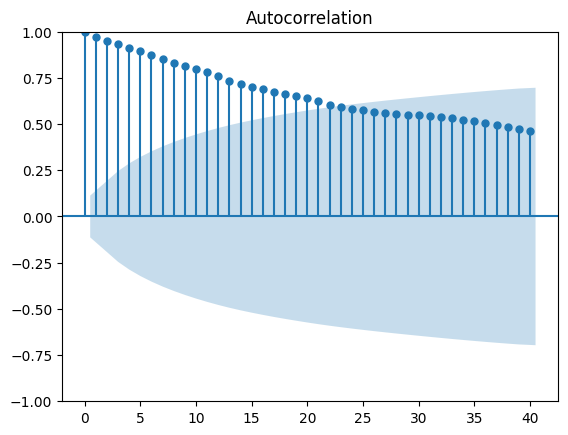

In [32]:
# plot auto-correlation

plt.figure(figsize=(10, 10))

# Plot autocorrelation
plot_acf(data['Close'], lags=40)

plt.show()

In [33]:
from statsmodels.tsa.stattools import acf

val = data['Close'].values

# Calculate autocorrelation and confidence intervals
autocorr, confint = acf(val, nlags=40, alpha=0.05, fft=True)

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: %s' % confint[i])
    print('---')


Lag: 0
Autocorrelation: 1.0
Confidence interval: [1. 1.]
---
Lag: 1
Autocorrelation: 0.9722555260721024
Confidence interval: [0.85909695 1.0854141 ]
---
Lag: 2
Autocorrelation: 0.951689492165452
Confidence interval: [0.75930123 1.14407776]
---
Lag: 3
Autocorrelation: 0.931299609403843
Confidence interval: [0.68592581 1.17667341]
---
Lag: 4
Autocorrelation: 0.9120885315664539
Confidence interval: [0.62499951 1.19917755]
---
Lag: 5
Autocorrelation: 0.8929610790556907
Confidence interval: [0.57089746 1.2150247 ]
---
Lag: 6
Autocorrelation: 0.8739702468797316
Confidence interval: [0.52162717 1.22631333]
---
Lag: 7
Autocorrelation: 0.853114430543195
Confidence interval: [0.47402741 1.23220145]
---
Lag: 8
Autocorrelation: 0.8331014186557135
Confidence interval: [0.4301798  1.23602304]
---
Lag: 9
Autocorrelation: 0.816887812232364
Confidence interval: [0.39248179 1.24129383]
---
Lag: 10
Autocorrelation: 0.7981809782757396
Confidence interval: [0.35409767 1.24226429]
---
Lag: 11
Autocorrelatio

nlags=40 specifies the number of lags to return autocorrelations for, and alpha=0.05 specifies a 95% confidence interval. The acf function returns two arrays: one for the autocorrelation values and one for the confidence intervals. If the autocorrelation for a given lag is outside its corresponding confidence interval, then it’s statistically significant.


When you perform the autocorrelation function (ACF) test:

- If the autocorrelation is significant for a given lag (i.e., it lies outside the confidence interval), it suggests that the value of a series at a point in time is influenced by its values at previous points in time. This can be an indication of seasonality or trend in your data.

- The number of significant lags can give you an idea about the order of an autoregressive model (if you’re planning to fit one to your data). For instance, if the first three lags are significant and the rest are within the confidence interval, it suggests that an AR(3) model might be a good fit for your data.

- If there are too many significant lags and no clear cut-off point, it might suggest that your data is not stationary and differencing might be needed to make it stationary.

    p: The autoregressive (AR) order, which is the number of lags of the differenced series to include in the model.
    d: The differencing order, which is the number of times you need to difference the series to make it stationary.
    q: The moving average (MA) order, which is the number of lags of the forecast errors to include in the model.

<Figure size 1000x1000 with 0 Axes>

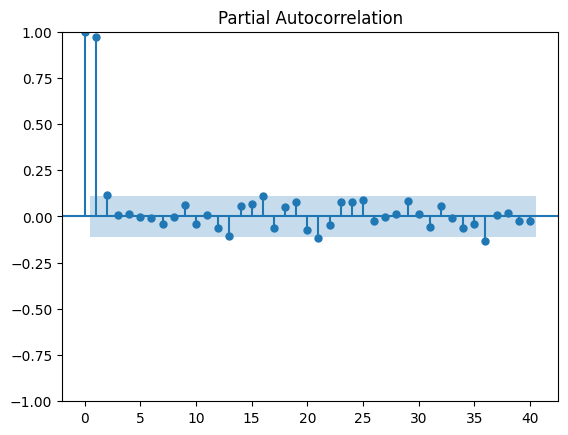

In [34]:
# plot partial auto-correlation

from statsmodels.graphics.tsaplots import plot_pacf

val = data['Close'].values

# Plot partial autocorrelation
plt.figure(figsize=(10, 10))

plot_pacf(val, lags=40)
plt.show()


In [35]:
from statsmodels.tsa.stattools import pacf

# Assuming 'df' is your DataFrame and 'Close' is the column with your time series data
val = data['Close'].values

# Calculate partial autocorrelation and confidence intervals
autocorr, confint = pacf(val, nlags=40, alpha=0.05, method='ols')

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Partial Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: [%s, %s]' % (confint[i, 0], confint[i, 1]))
    print('---')


Lag: 0
Partial Autocorrelation: 1.0
Confidence interval: [1.0, 1.0]
---
Lag: 1
Partial Autocorrelation: 0.9722651026463273
Confidence interval: [0.8591065292387101, 1.0854236760539444]
---
Lag: 2
Partial Autocorrelation: 0.11884957632113001
Confidence interval: [0.005691002913512835, 0.23200814972874717]
---
Lag: 3
Partial Autocorrelation: 0.013948451202691696
Confidence interval: [-0.09921012220492548, 0.12710702461030887]
---
Lag: 4
Partial Autocorrelation: 0.01332755438510784
Confidence interval: [-0.09983101902250933, 0.126486127792725]
---
Lag: 5
Partial Autocorrelation: 0.006213752004916086
Confidence interval: [-0.10694482140270109, 0.11937232541253326]
---
Lag: 6
Partial Autocorrelation: 0.00699904455030049
Confidence interval: [-0.10615952885731668, 0.12015761795791767]
---
Lag: 7
Partial Autocorrelation: -0.04206755494978572
Confidence interval: [-0.1552261283574029, 0.07109101845783145]
---
Lag: 8
Partial Autocorrelation: 0.006303972984981131
Confidence interval: [-0.1068546

PACF Value at Lag 0 (k = 0):

    The PACF at lag 0 is always 1, as the time series is perfectly correlated with itself at lag 0.

PACF Value at Other Lags (k > 0):

    The PACF at a particular lag (k) represents the correlation between the series values at time t and the values at time t-k after removing the effects of the lags between 1 and k-1.
    If the PACF at a specific lag is significantly different from zero, it suggests a direct relationship between the current value and the value at that lag.
    If the PACF is close to 1 or -1 at a certain lag (e.g., PACF = 0.8 or PACF = -0.8), it indicates a strong positive or negative correlation at that lag.
    Confidence Intervals:

    In the PACF plot, you will also see confidence intervals. A significant PACF value is one that falls outside the confidence interval.
    If a PACF value is outside the confidence interval, it suggests that there is a significant partial autocorrelation at that lag.
    A significant PACF value indicates a potential autoregressive (AR) term for your time series model, with the lag corresponding to the significant value.


### Making CLose Stationary

In [36]:
# take first order differencing of CLose

data['Close_diff'] = data['Close'].diff()

data.head()

,id,Date,Open,Close,Volume,Strategy,Close_diff
0,0,2015-06-01,66.208486,75.609978,298506300,1,NaN
1,1,2015-06-08,64.116235,74.443331,227974800,1,-1.166647
2,2,2015-06-15,47.701942,71.140831,250670900,2,-3.302500
3,3,2015-06-22,54.754816,72.881344,223614300,1,1.740512
4,4,2015-06-29,48.031899,66.284718,406814900,2,-6.596626


In [37]:
data.dropna(inplace=True)
data.head()


,id,Date,Open,Close,Volume,Strategy,Close_diff
1,1,2015-06-08,64.116235,74.443331,227974800,1,-1.166647
2,2,2015-06-15,47.701942,71.140831,250670900,2,-3.302500
3,3,2015-06-22,54.754816,72.881344,223614300,1,1.740512
4,4,2015-06-29,48.031899,66.284718,406814900,2,-6.596626
5,5,2015-07-06,51.374399,58.494017,590857400,2,-7.790701


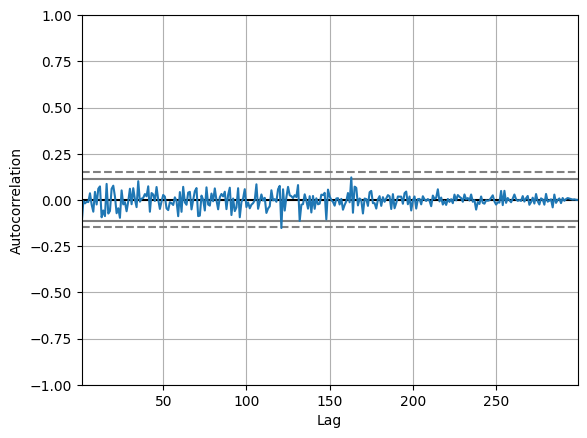

In [38]:
autocorrelation_plot(data['Close_diff'])
plt.show()

In [39]:
from statsmodels.tsa.stattools import adfuller

val = data['Close_diff'].values

result = adfuller(val)

print('ADF Statistic: %f' % result[0])
print('p-value: %f' % result[1])
print('Critical Values:')
for key, value in result[4].items():
    print('\t%s: %.3f' % (key, value))


ADF Statistic: -19.615948
p-value: 0.000000
Critical Values:
	1%: -3.452
	5%: -2.871
	10%: -2.572


We reject the null hypothesis. This suggests that there is enough evidence to conclude that the time series is stationary.

In [40]:
from statsmodels.tsa.stattools import acf

val = data['Close_diff'].values

# Calculate autocorrelation and confidence intervals
autocorr, confint = acf(val, nlags=40, alpha=0.05, fft=True)

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: %s' % confint[i])
    print('---')


Lag: 0
Autocorrelation: 1.0
Confidence interval: [1. 1.]
---
Lag: 1
Autocorrelation: -0.13084650746381185
Confidence interval: [-0.24419415 -0.01749886]
---
Lag: 2
Autocorrelation: -0.006661850506587902
Confidence interval: [-0.12193376  0.10861006]
---
Lag: 3
Autocorrelation: -0.018811020508990042
Confidence interval: [-0.13408788  0.09646584]
---
Lag: 4
Autocorrelation: -0.009951900122468018
Confidence interval: [-0.12526819  0.10536439]
---
Lag: 5
Autocorrelation: -0.011791351639912108
Confidence interval: [-0.12711868  0.10353597]
---
Lag: 6
Autocorrelation: 0.035929305537659995
Confidence interval: [-0.07941351  0.15127212]
---
Lag: 7
Autocorrelation: -0.025252803183200268
Confidence interval: [-0.14073932  0.09023371]
---
Lag: 8
Autocorrelation: -0.06361865056937116
Confidence interval: [-0.17917609  0.05193878]
---
Lag: 9
Autocorrelation: 0.04363155056106445
Confidence interval: [-0.07237499  0.1596381 ]
---
Lag: 10
Autocorrelation: -0.024657300301738412
Confidence interval: [-0

<Figure size 1000x1000 with 0 Axes>

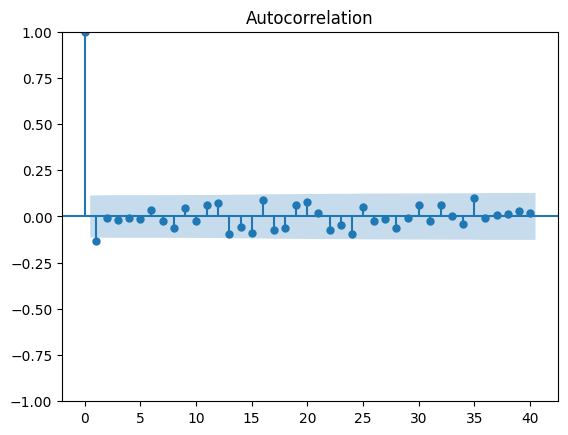

In [41]:
# plot auto-correlation

plt.figure(figsize=(10, 10))

# Plot autocorrelation
plot_acf(data['Close_diff'], lags=40)

plt.show()

In [42]:
from statsmodels.tsa.stattools import pacf

# Assuming 'df' is your DataFrame and 'Close' is the column with your time series data
val = data['Close_diff'].values

# Calculate partial autocorrelation and confidence intervals
autocorr, confint = pacf(val, nlags=40, alpha=0.05, method='ols')

# Print autocorrelations and confidence intervals
for i in range(len(autocorr)):
    print('Lag: %s' % i)
    print('Partial Autocorrelation: %s' % autocorr[i])
    print('Confidence interval: [%s, %s]' % (confint[i, 0], confint[i, 1]))
    print('---')


Lag: 0
Partial Autocorrelation: 1.0
Confidence interval: [1.0, 1.0]
---
Lag: 1
Partial Autocorrelation: -0.13108075362084112
Confidence interval: [-0.24442839745839737, -0.01773310978328488]
---
Lag: 2
Partial Autocorrelation: -0.024748371650287915
Confidence interval: [-0.13809601548784417, 0.08859927218726833]
---
Lag: 3
Partial Autocorrelation: -0.023719849317319693
Confidence interval: [-0.13706749315487593, 0.08962779452023656]
---
Lag: 4
Partial Autocorrelation: -0.016550828589001032
Confidence interval: [-0.12989847242655728, 0.09679681524855521]
---
Lag: 5
Partial Autocorrelation: -0.017660961555731013
Confidence interval: [-0.13100860539328726, 0.09568668228182522]
---
Lag: 6
Partial Autocorrelation: 0.03120723137645639
Confidence interval: [-0.08214041246109985, 0.14455487521401264]
---
Lag: 7
Partial Autocorrelation: -0.018287550569878824
Confidence interval: [-0.13163519440743507, 0.09506009326767742]
---
Lag: 8
Partial Autocorrelation: -0.07152746975839584
Confidence inter

<Figure size 1000x1000 with 0 Axes>

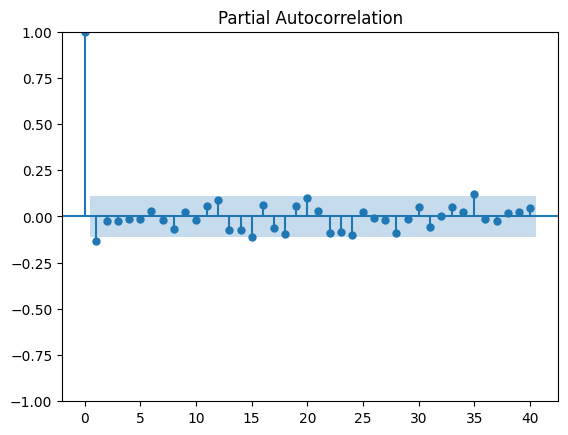

In [43]:
# plot auto-correlation

plt.figure(figsize=(10, 10))

# Plot autocorrelation
plot_pacf(data['Close_diff'], lags=40)

plt.show()

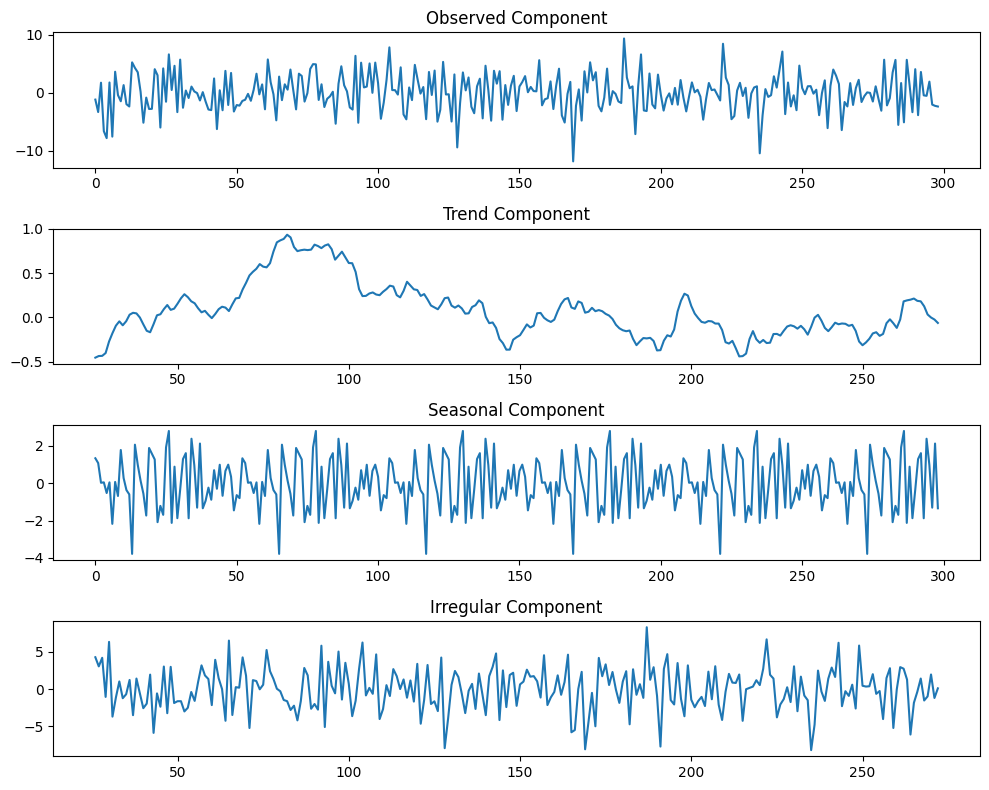

In [44]:
from statsmodels.tsa.seasonal import seasonal_decompose

# Assuming you have your time series data in a pandas DataFrame or Series
# You can create a sample time series for illustration purposes
# data = pd.Series([10, 12, 14, 16, 18, 20, 22, 24, 26, 28, 30, 32, 34, 36, 38, 40])

# Perform seasonal decomposition
result = seasonal_decompose(data['Close_diff'].values, model='additive', period=52)

# Plot the components
plt.figure(figsize=(10, 8))

plt.subplot(4, 1, 1)
plt.plot(result.observed)
plt.title("Observed Component")

plt.subplot(4, 1, 2)
plt.plot(result.trend)
plt.title("Trend Component")

plt.subplot(4, 1, 3)
plt.plot(result.seasonal)
plt.title("Seasonal Component")

plt.subplot(4, 1, 4)
plt.plot(result.resid)
plt.title("Irregular Component")

plt.tight_layout()
plt.show()


### REGRESSION PLOTS

<AxesSubplot:xlabel='Open', ylabel='Close'>

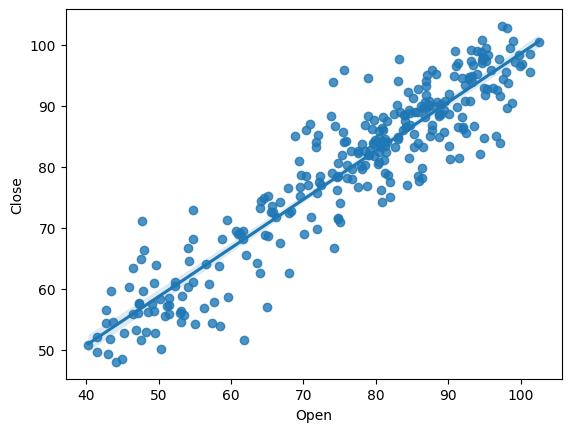

In [45]:
# reg plot

sns.regplot(x='Open', y='Close', data=data)


<AxesSubplot:xlabel='Volume', ylabel='Close'>

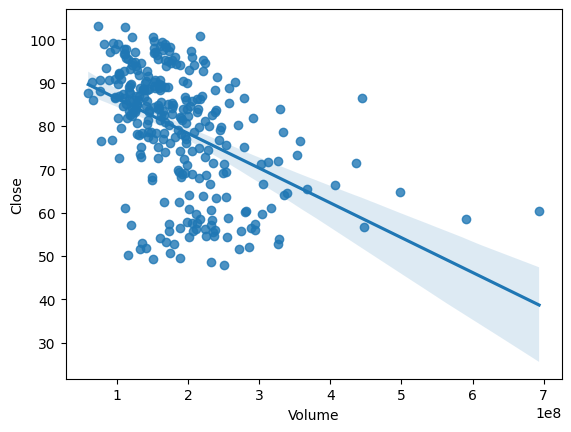

In [46]:
sns.regplot(x='Volume', y='Close', data=data)


<AxesSubplot:ylabel='Close'>

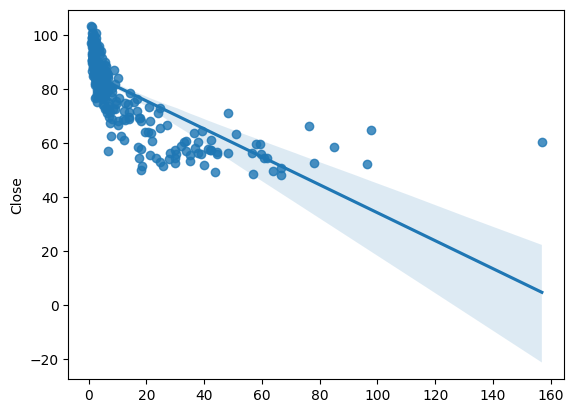

In [47]:
sns.regplot(x=data['Volume']/data['Open']**4, y='Close', data=data)


<AxesSubplot:xlabel='Volume', ylabel='Close'>

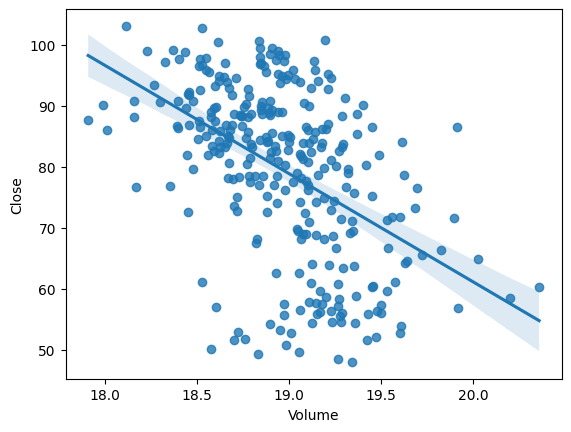

In [48]:
sns.regplot(x=np.log(data['Volume']), y='Close', data=data)


<AxesSubplot:ylabel='Close'>

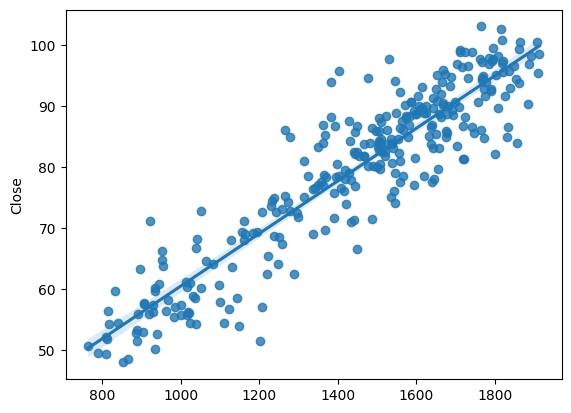

In [49]:
sns.regplot(x=np.log(data['Volume'])*data['Open'], y='Close', data=data)


# HELPER Functions

In [50]:
def smape_kun(y_true, y_pred):
    return np.mean(np.abs(y_pred - y_true) / (np.abs(y_pred) + np.abs(y_true)))

def temporal_metrics(y_pred,y_true):
    print("Mean Absolute Error: ",mean_absolute_error(y_true,y_pred))
    print("Mean Squared Error: ",mean_squared_error(y_true,y_pred))
    print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_true,y_pred)))
    print("Smape", smape_kun(y_true,y_pred))

def regression_metrics(y_pred,y_true):
    print("Mean Absolute Error: ",mean_absolute_error(y_true,y_pred))
    print("Mean Squared Error: ",mean_squared_error(y_true,y_pred))
    print("Root Mean Squared Error: ",np.sqrt(mean_squared_error(y_true,y_pred)))

def classification_metrics(y_pred,y_true):
    print("Accuracy: ",accuracy_score(y_true,y_pred))
    print("Precision: ",precision_score(y_true,y_pred, average='macro'))
    print("Recall: ",recall_score(y_true,y_pred, average='macro'))
    print("F1 Score: ",f1_score(y_true,y_pred, average='macro'))
    print("Confusion Matrix: \n",confusion_matrix(y_true,y_pred))

def train_ARIMA(data,order):
    model = ARIMA(data, order=order)
    model_fit = model.fit()
    aic = model_fit.aic
    return aic


def find_best_pdq(p_val,d_val,q_val,data):
        
    # Define the range of values for p, d, and q
    p_values = range(0, p_val)  # Replace with an appropriate range
    d_values = range(0, d_val)  # Replace with an appropriate range
    q_values = range(0, q_val)  # Replace with an appropriate range

    # Initialize variables to store best model and criterion value
    best_aic = float("inf")
    best_order=[0,0,0]

    # Perform a grid search to find the best ARIMA model
    for p in p_values:
        for d in d_values:
            for q in q_values:
                order = [p, d, q]
                try:
                    aic = train_ARIMA(data,order)
                    if aic < best_aic:
                        best_aic = aic
                        best_order = order
                except:
                    print(p,d,q)
                    continue

    # Print the best model and order
    print("Best AIC: {:.2f}".format(best_aic))
    print("Best ARIMA Order (p, d, q):", best_order)
    return best_order

    



# Feature Engineering

In [68]:
data= train.copy()


In [69]:
# classify Strategy as categorical variable
data['Strategy'] = data['Strategy'].astype('category')
data['Strategy'] = data['Strategy'].map({"Hold":1,"Buy":2,"Sell":0})
data['Strategy'].value_counts()

# convert Date to datetime
data['Date'] = pd.to_datetime(data['Date'])

data.head()

,id,Date,Open,Close,Volume,Strategy
0,0,2015-06-01,66.208486,75.609978,298506300,1
1,1,2015-06-08,64.116235,74.443331,227974800,1
2,2,2015-06-15,47.701942,71.140831,250670900,2
3,3,2015-06-22,54.754816,72.881344,223614300,1
4,4,2015-06-29,48.031899,66.284718,406814900,2


In [70]:
data['Market Participation']=data["Volume"]/ (data['Open'])**4
data['log_Volume']= np.log(data['Volume'])

In [71]:

window_size = 5 
# Calculate the moving average of the 'Open' and 'Volume' column
data['Open_MA'] = data['Open'].rolling(window=window_size).mean()
window_size= 5
data['Volume_MA'] = data['Volume'].rolling(window=window_size).mean()

# set null values to an array of elements for Open and Volume


# data.isna().sum()
data.head()

,id,Date,Open,Close,Volume,Strategy,Market Participation,log_Volume,Open_MA,Volume_MA
0,0,2015-06-01,66.208486,75.609978,298506300,1,15.534557,19.514302,NaN,NaN
1,1,2015-06-08,64.116235,74.443331,227974800,1,13.490088,19.244746,NaN,NaN
2,2,2015-06-15,47.701942,71.140831,250670900,2,48.412743,19.339651,NaN,NaN
3,3,2015-06-22,54.754816,72.881344,223614300,1,24.877702,19.225433,NaN,NaN
4,4,2015-06-29,48.031899,66.284718,406814900,2,76.432454,19.823869,56.162676,281516240.0


In [72]:
# feature engineering
data['Open_diff']= data["Open"].diff()
# data['Close_diff']= data["Close"].diff()
data['Volume_diff'] = data["Volume"].diff()

In [73]:

# Calculate MACD (Moving Average Convergence Divergence)
short_window = 14  # Adjust the short-term window
long_window = 21  # Adjust the long-term window

ema_short = data['Open'].ewm(span=short_window, adjust=True).mean()
ema_long = data['Open'].ewm(span=long_window, adjust=True).mean()

data['MACD'] = ema_short - ema_long

# Signal line for MACD
signal_window = 9  # Adjust the signal window
data['MACD_Signal'] = data['MACD'].ewm(span=signal_window, adjust=True).mean()

# Calculate the 14-day RSI
n = 14
delta = data['Open'].diff()
delta = delta[1:]  # Remove the first row of 'NaN' values
up_days = delta.copy()
down_days = delta.copy()
up_days[up_days < 0] = 0
down_days[down_days > 0] = 0
data['up_days'] = up_days
data['down_days'] = down_days
AVG_Gain = data['up_days'].rolling(window=n).mean()
AVG_Loss = abs(data['down_days'].rolling(window=n).mean())
RS = AVG_Gain / AVG_Loss
RSI = 100.0 - (100.0 / (1.0 + RS))
data['RSI'] = RSI

# add avg gain and loss
data['AVG_Gain'] = AVG_Gain
data['AVG_Loss'] = AVG_Loss


In [74]:

# set null vals to 0
data.fillna(0, inplace=True)

data.isna().sum()


id                      0
Date                    0
Open                    0
Close                   0
Volume                  0
Strategy                0
Market Participation    0
log_Volume              0
Open_MA                 0
Volume_MA               0
Open_diff               0
Volume_diff             0
MACD                    0
MACD_Signal             0
up_days                 0
down_days               0
RSI                     0
AVG_Gain                0
AVG_Loss                0
dtype: int64

In [75]:
data.head()

,id,Date,Open,Close,Volume,Strategy,Market Participation,log_Volume,Open_MA,Volume_MA,Open_diff,Volume_diff,MACD,MACD_Signal,up_days,down_days,RSI,AVG_Gain,AVG_Loss
0,0,2015-06-01,66.208486,75.609978,298506300,1,15.534557,19.514302,0.000000,0.0,0.000000,0.0,0.000000,0.000000,0.000000,0.000000,0.0,0.0,0.0
1,1,2015-06-08,64.116235,74.443331,227974800,1,13.490088,19.244746,0.000000,0.0,-2.092251,-70531500.0,-0.024908,-0.013838,0.000000,-2.092251,0.0,0.0,0.0
2,2,2015-06-15,47.701942,71.140831,250670900,2,48.412743,19.339651,0.000000,0.0,-16.414294,22696100.0,-0.301701,-0.131815,0.000000,-16.414294,0.0,0.0,0.0
3,3,2015-06-22,54.754816,72.881344,223614300,1,24.877702,19.225433,0.000000,0.0,7.052875,-27056600.0,-0.285817,-0.183983,7.052875,0.000000,0.0,0.0,0.0
4,4,2015-06-29,48.031899,66.284718,406814900,2,76.432454,19.823869,56.162676,281516240.0,-6.722917,183200600.0,-0.413026,-0.252118,0.000000,-6.722917,0.0,0.0,0.0


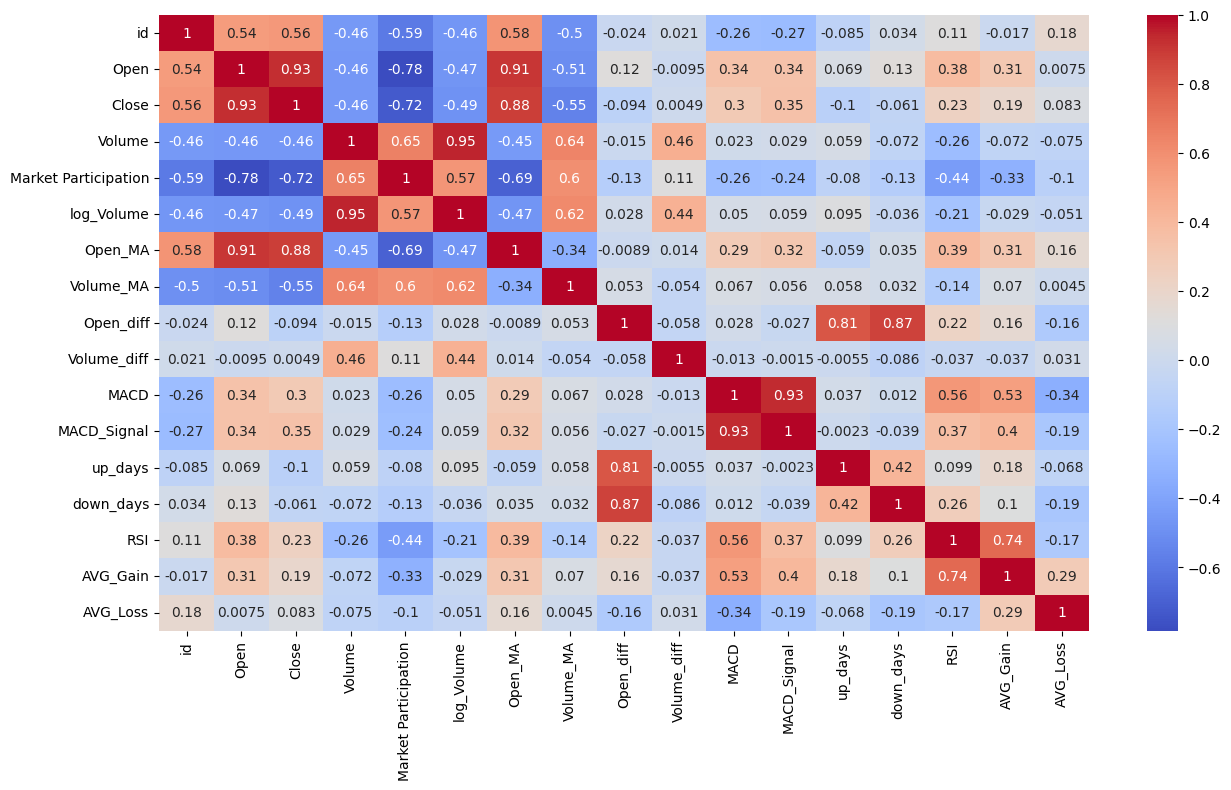

In [77]:
plt.figure(figsize=(15,8))
sns.heatmap(data.corr(),annot=True, cmap='coolwarm')
plt.show()

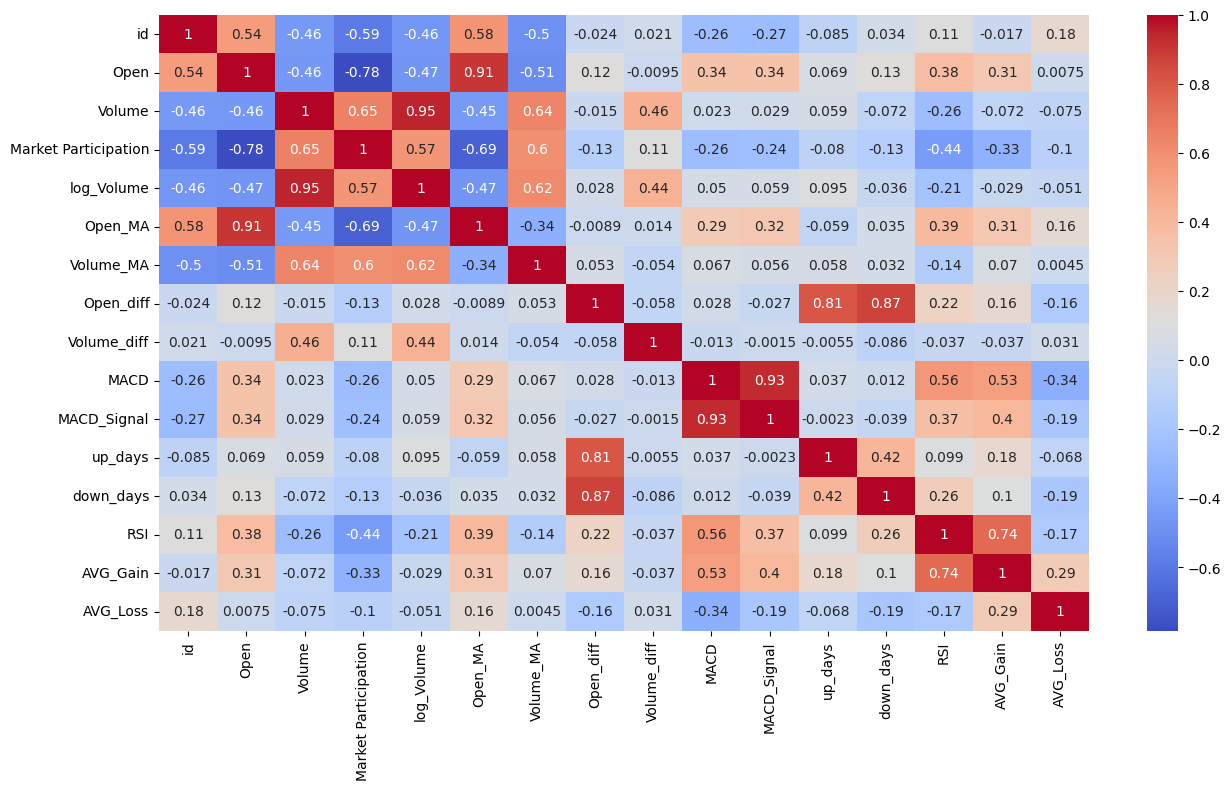

In [87]:
# ignore close and find correlation

d=data.drop(['Close'], axis=1)

plt.figure(figsize=(15,8))
sns.heatmap(d.corr(),annot=True, cmap='coolwarm')
plt.show()

In [88]:
# remove all correlated variables from d where correlation > 0.90

# Create correlation matrix

corr_matrix = d.corr().abs()
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape, dtype=bool), k=1))  # Select upper triangle of correlation matrix
to_drop = [column for column in upper.columns if any(
    upper[column] > 0.80)]  # Find index of feature columns with correlation greater than 0.90

to_drop

['log_Volume', 'Open_MA', 'MACD_Signal', 'up_days', 'down_days']

In [89]:

# Drop features
d.drop(d[to_drop], axis=1, inplace=True)

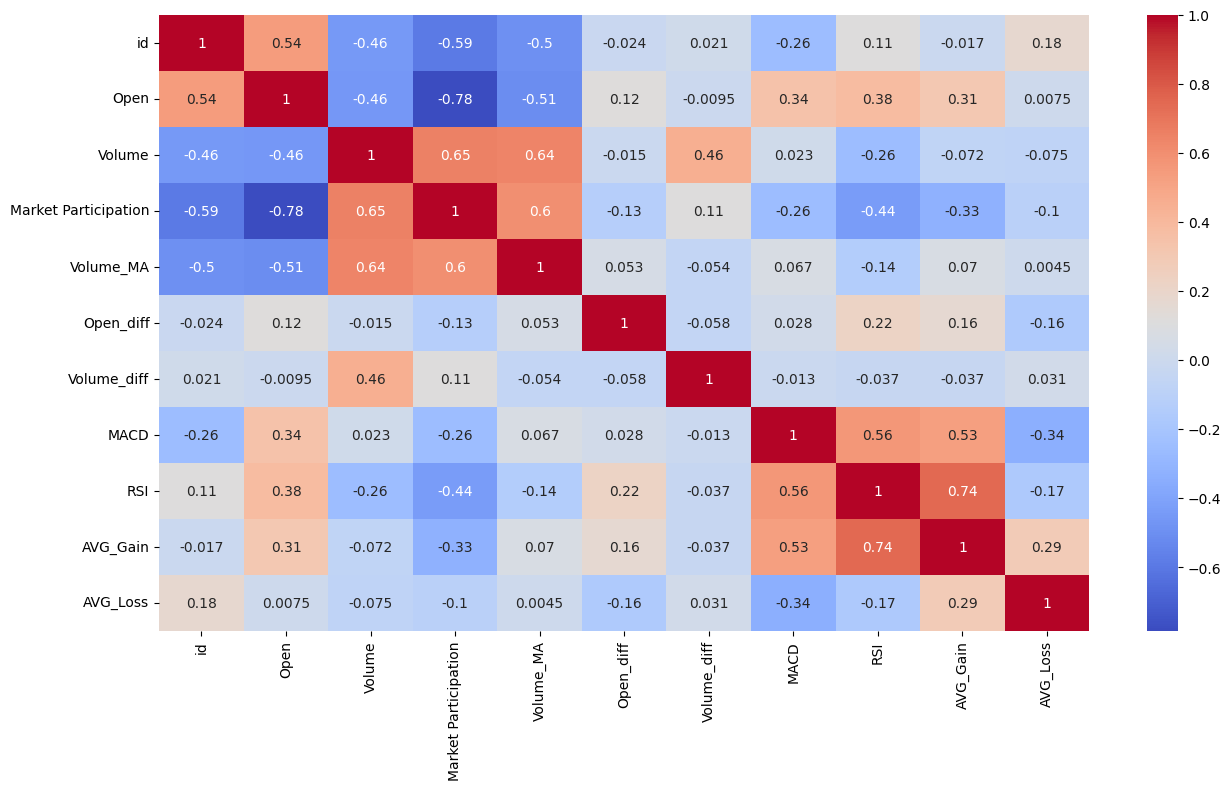

In [90]:
plt.figure(figsize=(15,8))
sns.heatmap(d.corr(),annot=True, cmap='coolwarm')
plt.show()

In [91]:
d.columns

Index(['id', 'Date', 'Open', 'Volume', 'Strategy', 'Market Participation',
       'Volume_MA', 'Open_diff', 'Volume_diff', 'MACD', 'RSI', 'AVG_Gain',
       'AVG_Loss'],
      dtype='object')